<a href="https://colab.research.google.com/github/guit2022/R-Net/blob/main/Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import dlib
import math
import numpy as np
import matplotlib.pyplot as plt

!pip install mtcnn

from mtcnn.mtcnn import MTCNN
import mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00


In [ ]:
def find_face(img):
    #dlib
    #print('new FD')
    dlib_detector = dlib.get_frontal_face_detector()
    #rects = []
    rects = dlib_detector(img, 0) #2nd argument could also be other values like 1
    if len(rects) > 0:
        print('DLIB-get_frontal_face_detector : 0')
        return rects
    elif len(rects) == 0:
        rects = dlib_detector(img, 1)
        if len(rects) > 0:
            print('DLIB-get_frontal_face_detector: 1')
            return rects
        elif len(rects) == 0:
            #dlib CNN
            cnn_face_detector = dlib.cnn_face_detection_model_v1('/content/dlibCNN_face_detector.dat')
            mmod_rects = cnn_face_detector(img, 1) #returns dlib.mmod_rectangles(dlib wrapper class having the rectangle and its confidence)
            rects = [d.rect for d in mmod_rects]
            #face = mmod_rects[0].rect  #gives the rectangle
            if len(rects) > 0:
                print('DLIB-cnn')
                return rects
            else:
                detector = MTCNN()
                faces = detector.detect_faces(img)
                rects = []
                for face in faces:
                    r = face["box"]
                    rec = dlib.rectangle(r[0], r[1], r[0]+r[2], r[1]+r[3])
                    rects.append(rec)
                if len(rects) > 0:
                    print('mtcnn')
                    return rects
                else:
                    print('Face not detected')
                    return []


In [ ]:
import cv2
img = cv2.imread('/content/img1.jpg')
find_face(img)

DLIB-get_frontal_face_detector : 0


rectangles[[(74, 74) (254, 254)]]

In [ ]:
def shape_to_np(shape, dtype="int"):

	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)

	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords


In [ ]:
s_predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')


In [ ]:
#s_predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

def face_align(img, desiredFaceHeight, desiredFaceWidth, desiredLeftEye, desiredChin):
    FACIAL_LANDMARKS_IDXS = {
    "mouth": (48, 68),
    "right_eyebrow": (17, 22),
    "left_eyebrow": (22, 27),
    "right_eye": (36, 42),
    "left_eye": (42, 48),
    "nose": (27, 36),
    "jaw": (0, 17),
    "chin": (8, 11) }
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #s_predictor = dlib.shape_predictor(os.path.join("D:\\","mazida","PREPROCESSING","shape_predictor_68_face_landmarks.dat"))
    face_rects = find_face(img)
    #print('face_rects type:', type(face_rects))
    output = []
    if len(face_rects) == 0:
        print('Face not Detected')
        return output
    for i in range(len(face_rects)):
        #shape = s_predictor(gray, rect)
        shape = s_predictor(img, face_rects[i])
        shape = shape_to_np(shape)

        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        leftMidEye = leftEyePts.mean(axis = 0)
        rightMidEye = rightEyePts.mean(axis = 0)
        #cv2.circle(img, (int(leftMidEye[0]), int(leftMidEye[1])), 3, (255, 0, 0), -1)
        #cv2.circle(img, (int(rightMidEye[0]), int(rightMidEye[1])), 3, (255, 0, 0), -1)

        #cv2.line(img, (int(leftMidEye[0]), int(leftMidEye[1])), (int(rightMidEye[0]), int(rightMidEye[1])), (255, 0, 0), 2)
        #cv2.line(img, (int(rightMidEye[0]), int(rightMidEye[1])), (int(leftMidEye[0]), int(rightMidEye[1])), (255, 0, 0), 2)

        dX = leftMidEye[0] - rightMidEye[0]
        dY = leftMidEye[1] - rightMidEye[1]
        #ANGLE of rotation
        angle  = math.degrees(math.atan(dY/dX)) # -180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - desiredLeftEye[0]          #Subtracted from 1 because the right eye should be equidistant from the right edge of the image as the x coordinate of the left eye
        dist = np.sqrt( dX*dX + dY*dY)
        desiredDist = desiredRightEyeX - desiredLeftEye[0]
        desiredDist *= desiredFaceWidth
        scale = desiredDist / dist

        #print('scale:', scale)

        #check if chin is inside the frame
        (cStart, cEnd) = FACIAL_LANDMARKS_IDXS["chin"]
        chinPts = shape[cStart:cEnd]
        for s in shape:
            cv2.circle(img, (s[0], s[1]), 1, (0, 0, 255), -1)

        MidChin = chinPts.mean(axis = 0)
        #cv2.circle(img, (int(MidChin[0]), int(MidChin[1])), 1, (0, 255, 0), -1)
        #plt.imshow(img)
        eyeChinDist = MidChin[1] - leftMidEye[1]
        scaledEyeChinDist = scale*eyeChinDist

        desiredEyeChin = (1-(desiredLeftEye[1] + desiredChin[1]))*desiredFaceHeight

        if scaledEyeChinDist > 1.3*desiredEyeChin : #i.e., Chin went outside the frame
            scale = desiredEyeChin/eyeChinDist + 0.3*(scale - desiredEyeChin/eyeChinDist)
            #print('without 0.3--',desiredEyeChin/eyeChinDist )
            #print('NEW scale modified', scale)

        eyesCenter = ((leftMidEye[0] + rightMidEye[0])/2, (leftMidEye[1] + rightMidEye[1])/2 )

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = desiredFaceWidth * 0.5
        tY = desiredFaceHeight * desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformatio
        (w, h) = (desiredFaceWidth, desiredFaceHeight)
        output.append( cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC))

        f=plt.figure()
        f.suptitle('Original')
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

        f=plt.figure()
        plt.xticks([])
        plt.yticks([])
        f.suptitle('Aligned')
        plt.imshow(output[0])

    return output

DLIB-get_frontal_face_detector : 0


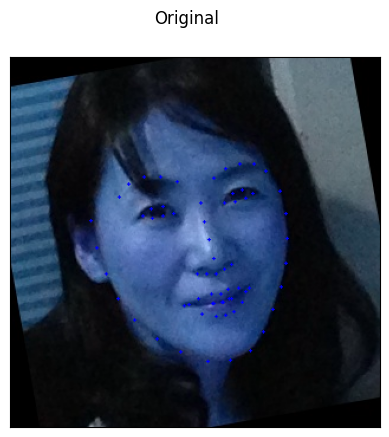

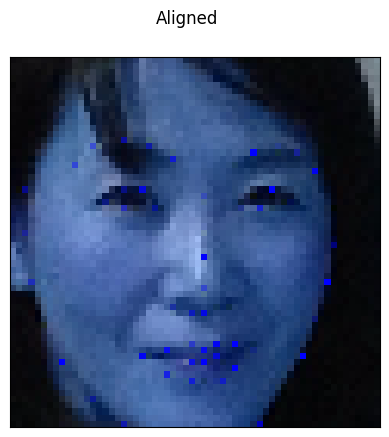

In [ ]:
img = cv2.imread('/content/img1.jpg')
if(img is None): #None= empty object;Image was NOT read
  print('face not detected for ', i)
else:
  fa = face_align(img, 60, 60, ( 0.32, 0.38), (0.5,0.001))
  if len(fa) > 0:
    cv2.imwrite('/content/out_img1.jpg', fa[0])


In [ ]:
def read_align_save():

    inp='/content/img1.jpg'
    out = ''
    #out_dirs = ['E:\\FACE_DATABASES\\BUPT-Balancedface\\ALIGNED IMAGES\\AFRICAN', 'E:\\FACE_DATABASES\\BUPT-Balancedface\\ALIGNED IMAGES\\ASIAN',
                #'E:\\FACE_DATABASES\\BUPT-Balancedface\\ALIGNED IMAGES\\CAUCA', 'E:\\FACE_DATABASES\\BUPT-Balancedface\\ALIGNED IMAGES\\INDIAN']
    #image_names = mylistdir(os.path.join(inp,d))
    image_names = os.listdir(inp)
    for i in image_names:
        img = cv2.imread(os.path.join(inp,i))
        if(img is None): #None= empty object;Image was NOT read
            print('face not detected for ', i)
            continue
        fa = face_align(img, 60, 60, ( 0.32, 0.38), (0.5,0.001))
        if len(fa) > 0:
            cv2.imwrite(out+'\\'+ i +'.jpg', fa[0])

    return